In [43]:
# Install required packages
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.9.0+cu111.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


In [44]:
## Importing library
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv 
from torch_geometric.utils import to_networkx, from_networkx

In [45]:
# Helper fucntion for visualization
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set1")    
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch:{epoch}, Loss {loss.item():.4f}',fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G,seed=42),with_labels=False,
                        node_color=color,cmap="Set2")
    plt.show()

## Loading KarateClub dataset

In [46]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset:{dataset}')
print("=======")
print(f"Number of Graph: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of edges: {dataset.num_classes}")


Dataset:KarateClub()
Number of Graph: 1
Number of features: 34
Number of edges: 4


In [47]:
data = dataset[0]

print(data)
print("===============")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {(2*data.num_edges)/ data.num_nodes:.2f}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loop: {data.has_isolated_nodes()}')
print(f'Is directed: {data.is_directed()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 9.18
Number of training nodes: 4
Has isolated nodes: False
Has self-loop: False
Is directed: False


34


/tmp/ipykernel_1787836/1078836082.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


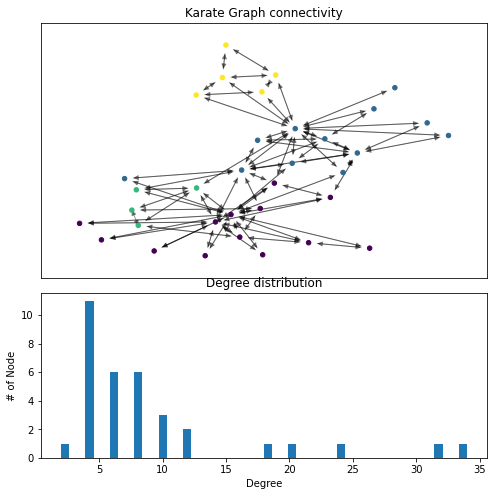

In [48]:
G = to_networkx(dataset[0],to_undirected=False) 

degree_sequence = sorted([d for n,d in G.degree()])
degree_counter = Counter(degree_sequence)
max_degree = max(degree_sequence)
print(max_degree)
fig = plt.figure("Degree of a random graph",figsize=(8,8))
axgrid = fig.add_gridspec(5,4)

ax0 = fig.add_subplot(axgrid[:3,:])
pos = nx.spring_layout(G, seed=24)
nx.draw_networkx_nodes(G, pos, ax=ax0, node_size=20,node_color=data.y)
nx.draw_networkx_edges(G, pos, ax=ax0, alpha=0.4)
ax0.set_title("Karate Graph connectivity")
#ax0.set_axis_off()

# ax1 = fig.add_subplot(axgrid[3:,:2])
# ax1.hist(degree_sequence,bins=50)
# ax1.set_ylabel("# of Node")
# ax1.set_xlabel("Degree")
# ax1.set_title("Degree distribution")

ax2 = fig.add_subplot(axgrid[3:,:])
ax2.hist(degree_sequence,bins=50)
ax2.set_ylabel("# of Node")
ax2.set_xlabel("Degree")
ax2.set_title("Degree distribution")


fig.show()

In [49]:
from torch import nn

###  Model Design

In [50]:
class GCN(torch.nn.Module):
    def __init__(self):
        ## If we are using python <3.3 we sould write supper(GCN,self).__init()__
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_node_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2,dataset.num_classes)
    def forward(self,x,edge_index):
        h = self.conv1(x,edge_index)
        h = h.tanh()
        h = self.conv2(h,edge_index)
        h = h.tanh()
        h = self.conv3(h,edge_index)
        h = h.tanh()

        out = self.classifier(h)

        return out, h
model = GCN()
print(model)
        


GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


## Nodes embeding before training

Embedding shape: [34, 2]


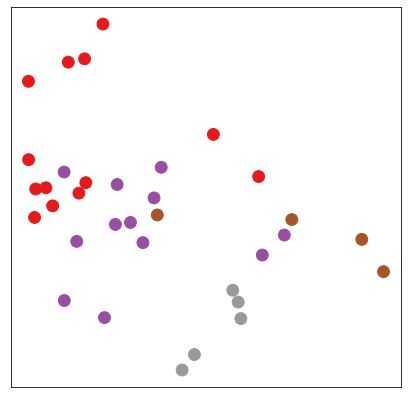

In [51]:

model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

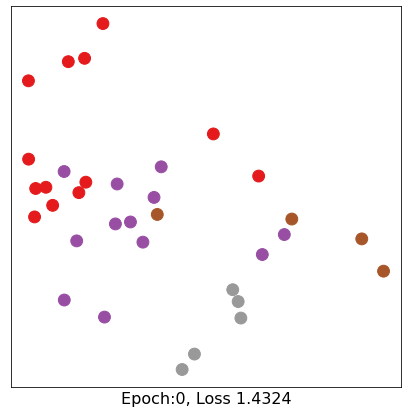

0 tensor(1.4324, grad_fn=<NllLossBackward>)


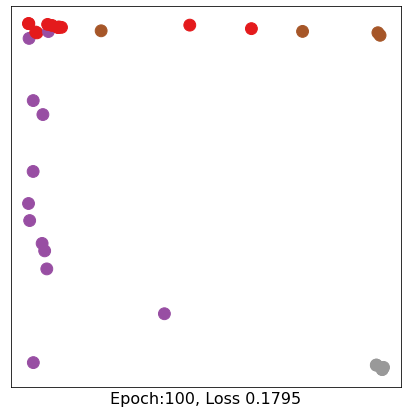

100 tensor(0.1795, grad_fn=<NllLossBackward>)


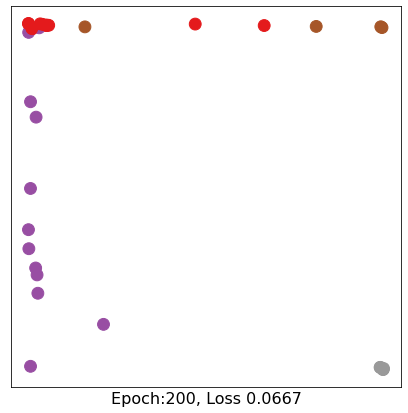

200 tensor(0.0667, grad_fn=<NllLossBackward>)


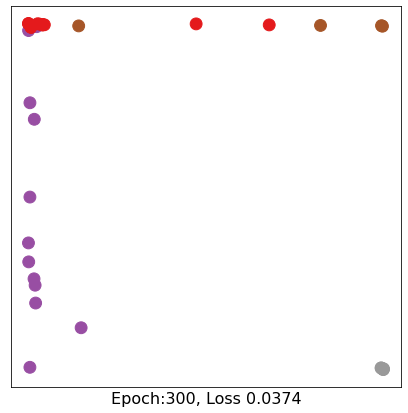

300 tensor(0.0374, grad_fn=<NllLossBackward>)


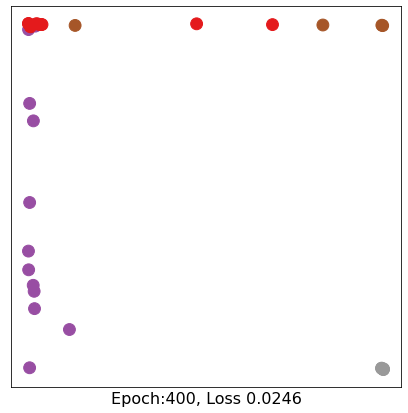

400 tensor(0.0246, grad_fn=<NllLossBackward>)


In [55]:
import time 
model = GCN()

criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(),lr=0.01) # Adam optimizer

def train(data):
    optimizer.zero_grad()
    out,h = model(data.x,data.edge_index)
    loss = criterion(out[data.train_mask],data.y[data.train_mask])
    loss.backward() # Derivce gradients
    optimizer.step()
    return loss,h

for epoch in range(500):
    loss,h = train(data)
    if epoch%100 == 0:
        visualize(h,color=data.y,epoch=epoch,loss=loss)
        print(epoch,loss)
        time.sleep(0.5)

